## IMPORTACIÓ INFORMACIÓ DE SABIO-RK

Generem un document csv on hi guardem els camps SabioReaction ID, Name, Role i Smiles de totes les reaccions químiques presents a la base de dades.

In [4]:
#install
import requests
import pandas as pd 

from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'


import os.path 

datafile = "data/smiles.csv"

if os.path.exists(datafile): 
    print(datafile, " exists") 
else: 
    print("Generating ",datafile)

    QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/searchReactionParticipants'

    query = {"SabioReactionID":"*", "fields[]":["Name","Role", "Smiles"]}

    request = requests.post(QUERY_URL, params = query) 
    request.raise_for_status() 

    print(request.text)

    # results

    fh=open("data/smiles.csv", "w")

    fh.write(request.text)



data/smiles.csv  exists


## DATAFRAME DEL FITXER smiles.csv

Creem un dataframe del fitxer smiles.csv obtingut de la base de dades Sabio-RK i el llegim. El document separa la informació per tabilació ('\t')

In [5]:
df = pd.read_csv(datafile, sep='\t')
print(df)

       SabioReactionID                              Name       Role  \
0                    1       alpha-D-Glucose 6-phosphate  Substrate   
1                    1       beta-D-Fructose 6-phosphate    Product   
2                    2                               ATP  Substrate   
3                    2  beta-D-Fructose 1,6-bisphosphate    Product   
4                    2                               ADP    Product   
...                ...                               ...        ...   
62291            16513                                H+    Product   
62292            16513                                O2  Substrate   
62293            16513                                CO    Product   
62294            16513      2-Heptyl-3-hydroxy-quinolone  Substrate   
62295            16513        n-Octanoylanthranilic acid    Product   

                                                  Smiles  
0      C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O...  
1      C([C@@H]1[C@H]([C@@H](

## Generem un DF curt per a fer proves

Crear smiles reacció:

In [6]:
input='data/smilestest.csv'
output='data/ReactionSmilesTest.csv'

df1 = pd.read_csv(input, sep='\t')

#Volem eliminar tota la informació de les reaccions que tinguin algun valor nul en els seus subtrats i productes a la columna smiles.

#Primer afegim 0 on tronem valors NaN a la columna Smiles del dataframe.
df1['Smiles'] = df1['Smiles'].fillna(0)

# generem una llista buida on guardarem el SabioReactionID dels substrats i productes que s'hagin d'elimianr 
list1 = [] 
#smiles=row["Smiles"] 

# iterem el df1   
for i in range(len(df1)): 

    # Si Smiles es igual a = afegim el SabioReactionID a la list1 
    if df1.loc[i,'Smiles'] == 0: 
        list1.append(df1.loc[i,'SabioReactionID']) 

#Eliminem del df1 tots els substrats i productes que tinguin el SabioReactionID igual que el que s'ha guardat a la llista
df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 
print(df)

#A partir del dataframe sense missing values generem el dataframe curt per fer proves.
#Generem un dataframe buit amb les columnes SabioID i Reaction de 11 files.
df = df.reset_index()  #la funció rest_index() restableix l'índex del dataframe, estableix una llista del 0 fins a la longitud del dataframe
numrows=11
df2 = pd.DataFrame(columns=["SabioID", "Reaction"]) #, index=range(numrows))
#print(df2)

#Creem dues llistes buides amb tants strings com files (en aquest cas 11 numrows=11). Generem una llista R per guardar els reactius i una llista P per guardar els productes.
R=[""]*(numrows+1)
P=[""]*(numrows+1)
isFirstR=[True]*(numrows+1)
isFirstP=[True]*(numrows+1)

def check_smiles(smiles):
    print(smiles)
    if not smiles:
        print('Wrong SMILES for:',smiles)
        return 0
    return 1

#Fem una iteració per cada fila del dataframe amb el command: for index, row in df.iterrows():
for index, row in df.iterrows():
    rid=row['SabioReactionID']
    #print('RID:',rid,isFirstR[rid],isFirstP[rid])
    #irid=int(rid)
    #print(rid)
    #print(type(rid))
    
    name=row["Name"]
    smiles=row["Smiles"]
    if check_smiles(smiles) == 0:
        break
   
    role=row["Role"]
    if role == "Substrate": 
        
        if isFirstR[rid]:
            R[rid]=R[rid] + smiles 
            isFirstR[rid]= False
        else:
            R[rid]=R[rid] + "." + smiles
            
        
    elif role == "Product":
        if isFirstP[rid]:
            P[rid]=P[rid]+smiles
            isFirstP[rid]=False
        else:
            P[rid]=P[rid] +"."+ smiles
    else:
        print("error, name")
    print(R[rid],P[rid])
    df2.at[rid, "SabioID"]=rid
    
for i in range(numrows):
    print(R[i]+">"+P[i])
    df2.at[i, "Reaction"]=R[i]+">"+P[i]

  

df2.drop(df2.tail(2).index,inplace=True)
print(df2)

#obtenim ReactionSmilesTest.csv.
df2.to_csv(output)


    SabioReactionID                              Name       Role  \
0                 1       alpha-D-Glucose 6-phosphate  Substrate   
1                 1       beta-D-Fructose 6-phosphate    Product   
2                 2                               ATP  Substrate   
3                 2  beta-D-Fructose 1,6-bisphosphate    Product   
4                 2                               ADP    Product   
5                 2       beta-D-Fructose 6-phosphate  Substrate   
6                 3      D-Glyceraldehyde 3-phosphate    Product   
7                 3               Glycerone phosphate    Product   
8                 3  beta-D-Fructose 1,6-bisphosphate  Substrate   
9                 4      D-Glyceraldehyde 3-phosphate  Substrate   
10                4               Glycerone phosphate    Product   
11                5                                H+    Product   
12                5                              NADH    Product   
13                5      D-Glyceraldehyde 3-phos

Genrem csv amb els SMILES de cada substrat i producte per separat per poder treballar amb RDKit i obtenir els features. 

In [7]:
input='data/smilestest.csv'
output='data/moleculesSmilesTest.csv'

df1 = pd.read_csv(input, sep='\t')

df1['Smiles'] = df1['Smiles'].fillna(0)
# create an empty list  
list1 = [] 
#smiles=row["Smiles"] 
# iterate over each row of dataframe   
for i in range(len(df1)): 

    # check if Smiles is 0 then append the SabioreactionID to list1  
    if df1.loc[i,'Smiles'] == 0: 
        list1.append(df1.loc[i,'SabioReactionID']) 

df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 
# Print the updated dataframe 
#print(df)


dfmolecules = df.drop_duplicates(subset="Smiles")

print(dfmolecules)
dfmolecules.to_csv(output)

    SabioReactionID                              Name       Role  \
0                 1       alpha-D-Glucose 6-phosphate  Substrate   
1                 1       beta-D-Fructose 6-phosphate    Product   
2                 2                               ATP  Substrate   
3                 2  beta-D-Fructose 1,6-bisphosphate    Product   
4                 2                               ADP    Product   
6                 3      D-Glyceraldehyde 3-phosphate    Product   
7                 3               Glycerone phosphate    Product   
11                5                                H+    Product   
12                5                              NADH    Product   
14                5        Glycerate 1,3-bisphosphate    Product   
15                5                         Phosphate  Substrate   
16                5                              NAD+  Substrate   
18                6             Glycerate 3-phosphate  Substrate   
23                8                             

# RDKit
 És una llibreria de codi obert de química computacional de python. Està dissenyat per a la manipulació de molècules i estructures químiques. RDKit té moltes funcions algunes d'elles són la conversió entre diferents formats de fitxers de molècules, la generació d'estructures moleculars, el càlcul de propietats físico-químiques de les molècules, com ara la solubilitat, el pes molecular, el nombre d'àtoms rotatius, la càrrega, etc. També permet generar visualitzacions 2D i 3D de molècules. Nosaltres l'utilizarem per a obtenir les _features_ , propietats fisico-químiques, que ens serviran de _finguerprints_ per a la generació del model ML. 

 Descriptors RDKit:

- Pes molecular: El pes molecular d'una molècula pot estar relacionat amb la seva activitat enzimàtica, ja que les molècules més grans o més complexes poden tenir més probabilitats d'interaccionar amb enzims específics. 

- Lipofílicitat: Capacitat d'un compost a dissoldre's en lípids o dissolvents no polars.

- Àrea de superfície polar topològica (TPSA) Chem.Descriptors.TPSA(): és una mesura de l'àrea superficial d'una molècula que és polar o capaç de participar en l'enllaç d'hidrogen. La TPSA pot estar relacionada amb l'activitat enzimàtica, ja que molts enzims tenen llocs actius polars o carregats. 

- Nombre d'heteroàtoms. NumHeteroatoms()

- Nombre d'anells. RingCount()

- Nombre d'anells aromàtis. NumAromaticRings()

- Nombre d'àtoms pesants: Chem.Descriptors.HeavyAtomCount(mol)

- Nombre d'anells alifàtics: Chem.Descriptors.NumAliphaticRings(mol)

- Fraction of carbons that are sp3 hybridized: Chem.Descriptors.FractionCSP3(mol)

- Number of chiral centers: Chem.Descriptors.NumChiralCenters(mol)

- Balaban J index: Chem.Descriptors.BalabanJ(mol) : L'índex J de Balaban mesura el grau d'insaturació d'una molècula. Està relacionat amb la reactivitat química i l'estabilitat d'una molècula, així com amb la seva aromaticitat. Les molècules amb índex més alts tendeixen a tenir graus més alts d'insaturació i, per tant, són més reactives mentre que les molècules amb índex més baixos solen ser més estables.

- Number of rotatable bonds: Chem.Descriptors.NumRotatableBonds(mol)

In [51]:
#df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
#df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
#df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [8]:
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
import matplotlib.pyplot as plt

df1 = pd.read_csv('data/moleculesSmilesTest.csv', sep=',')
df1.head()
df1['mol']=df1['Smiles'].apply(lambda x: Chem.MolFromSmiles(x)) #transformem la columna "Smiles" en mol per començar a treballar amb RDKit
print(type(df1['mol'][0])) #comprovem que hem genereat la classe rdkit.Chem.rdchem.Mol
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
output='data/fingerprintTest.csv'

mols = df1['mol']

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol


def features(mol,data):
    #Extract properties using RDKit functions
    smiles = Chem.MolToSmiles(mol)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw= Chem.rdMolDescriptors.CalcExactMolWt(mol) #pes molecular
    logp=Chem.Descriptors.MolLogP(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    num_rc=Chem.Descriptors.RingCount(mol)
    num_AR=Chem.Descriptors.NumAromaticRings(mol)
    num_HAC=Chem.Descriptors.HeavyAtomCount(mol)
    num_AR=Chem.Descriptors.NumAliphaticRings(mol)
    CSP3=Chem.Descriptors.FractionCSP3(mol)
    BJI=Chem.Descriptors.BalabanJ(mol)
    num_RB=Chem.Descriptors.NumRotatableBonds(mol)
    num_hbd = Chem.rdMolDescriptors.CalcNumHBD(mol)
    num_hba = Chem.rdMolDescriptors.CalcNumHBA(mol)
   

    #Append results in a data list
    data.append([smiles,formula,mw,logp, tpsa, num_rc, num_AR, num_HAC, num_AR, CSP3, BJI, num_RB, num_hbd, num_hba])
    return

data = []

for mol in mols:
    features(mol,data)

#We have a list with information. Creation of a Dataframe:
df= pd.DataFrame(data,columns=['SMILES','Formula','MW','logP',"TPSA", "Rings Count", "Aromatic Rings", "Heavy atoms cout", "Alifatic Rings",  "CSP3",  "BalabanJ", "RotatableBonds", "H-bond donor", "H-bond acceptor"])
df["SabioReactionID"]= df1["SabioReactionID"]
df["Role"]=df1["Role"]
df["Name"]=df1["Name"]
print(df)

df.to_csv(output)



<class 'rdkit.Chem.rdchem.Mol'>
                                               SMILES         Formula  \
0   O=P(O)(O)OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@...        C6H13O9P   
1      O=P(O)(O)OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@@H]1O        C6H13O9P   
2   Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...   C10H16N5O13P3   
3              O=P(O)(O)OCC1OC(O)(COP(=O)(O)O)C(O)C1O      C6H14O12P2   
4     Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O   C10H15N5O10P2   
5                                  O=CC(O)COP(=O)(O)O         C3H7O6P   
6                                  O=C(CO)COP(=O)(O)O         C3H7O6P   
7                                                 [H]               H   
8   NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...   C21H29N7O14P2   
9                      O=C(OP(=O)(O)O)C(O)COP(=O)(O)O       C3H8O10P2   
10                                         O=P(O)(O)O           H3O4P   
11  NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...  C21H28N7O14P2+   
12                 

[18:38:36] WARNING: not removing hydrogen atom without neighbors


Fem un estudi dels diferents descriptors:

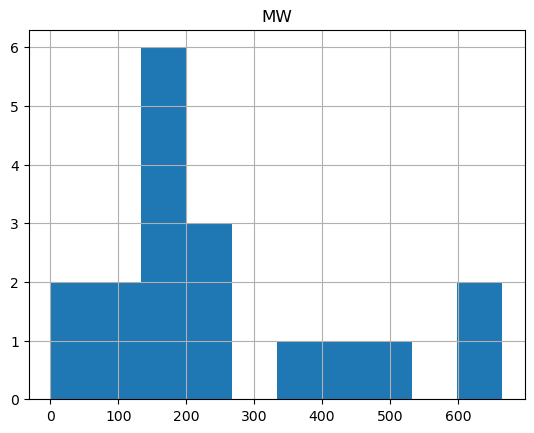

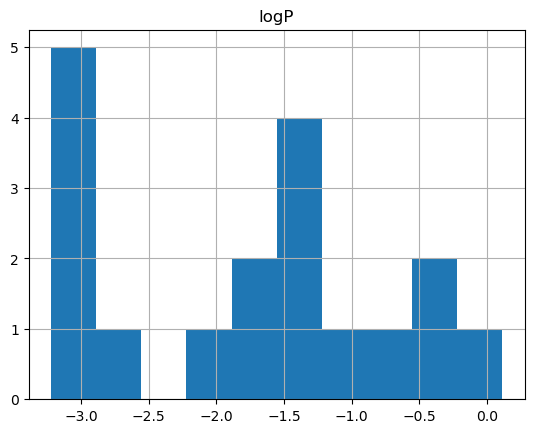

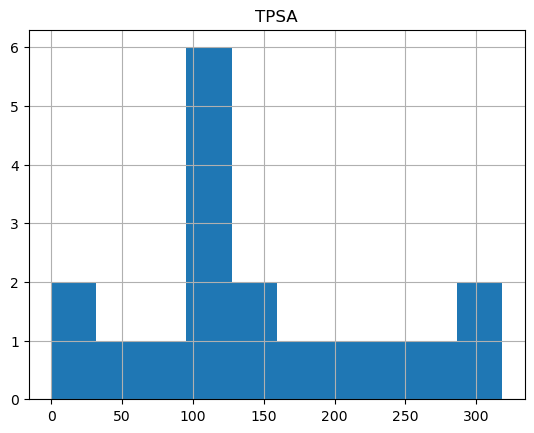

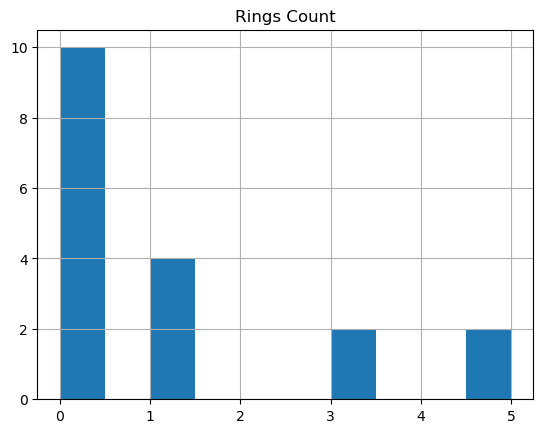

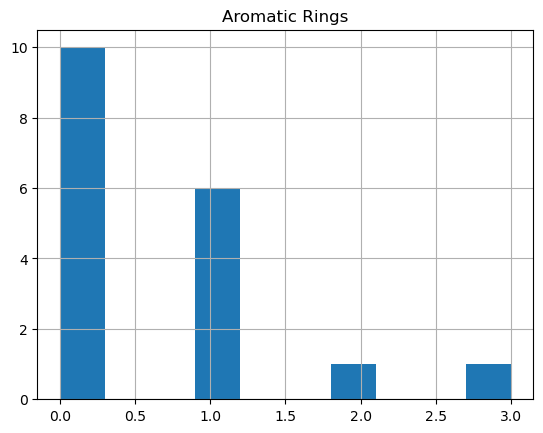

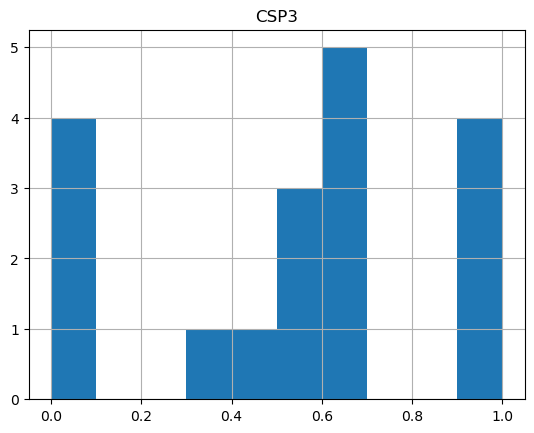

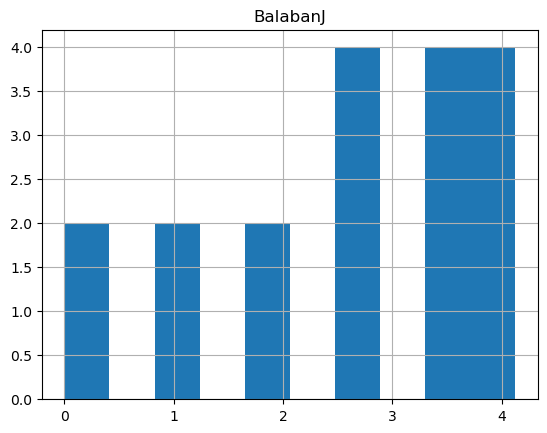

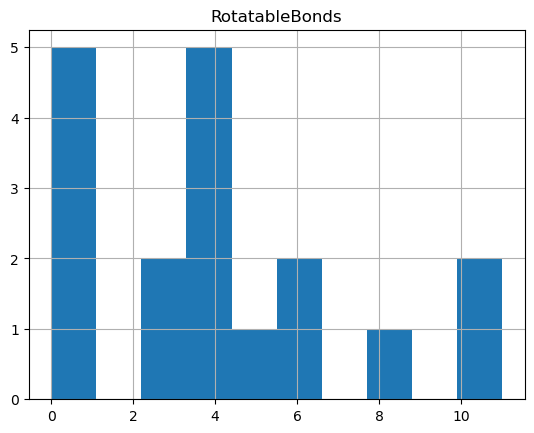

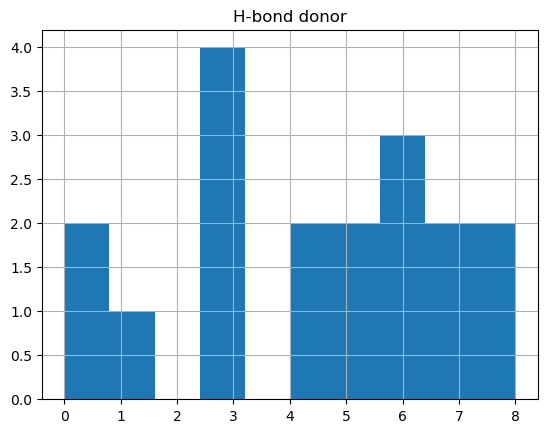

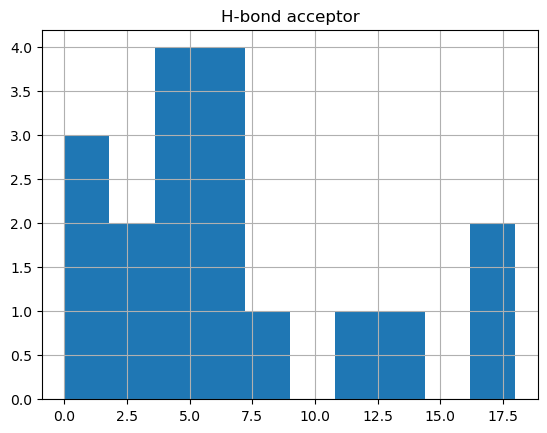

In [487]:
hist1=df.hist(column='MW')
hist2=df.hist(column='logP')
hist3=df.hist(column='TPSA')
hist4=df.hist(column='Rings Count')
hist5=df.hist(column='Aromatic Rings')
hist6=df.hist(column='CSP3')
hist7=df.hist(column='BalabanJ')
hist8=df.hist(column='RotatableBonds')
hist9=df.hist(column='H-bond donor')
hist10=df.hist(column='H-bond acceptor')


Generem un fitxer csv per introduir al programa Chemprop. El fitxer ha de tenir la columna: ReactionSmiles Sabio ID i la suma de fingerprints dels seus substrats i productes. 

In [488]:
input='data/FingerprintTest.csv'
df= pd.read_csv('data/FingerprintTest.csv', sep=',')




In [480]:
input='data/FingerprintTest.csv'
output='data/ChempropTest.csv'

# Sumem els valors de MW
df = pd.read_csv(input, sep=',')

SMW = {}
for index, row in df.iterrows():
    rid=row['SabioReactionID']
    role=row["Role"]
    MW=row["MW"]
    if rid not in SMW:
        SMW[rid] = 0
    if role == "Product":
        SMW[rid] += MW
    
mw = pd.DataFrame.from_dict(SMW, orient='index', columns=['SMW'])  
print(mw)


           SMW
1   260.029719
2   767.025464
3   339.996049
5   932.091867
6     0.000000
8   185.992939
9     0.000000
10    0.000000


In [472]:
# Sumem els valors de lipofilicitat dels substrats:
df = pd.read_csv(input, sep=',')


slogP = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    logP = row['logP']
    if rid not in slogP:
        slogP[rid] = 0
    if role == 'Substrate':
        slogP[rid] += logP

df2i = pd.DataFrame.from_dict(slogP, orient='index', columns=['slogP'])   

print(df2)

     slogP
1  -3.1044
2  -1.6290
3   0.0000
5  -3.9445
6  -1.4588
8  -1.4588
9  -0.3400
10 -3.2214


In [473]:
# Sumem els valors de lipofilicitat dels productes:
df = pd.read_csv(input, sep=',')


plogP = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    logP = row['logP']
    if rid not in plogP:
        plogP[rid] = 0
    if role == 'Product':
        plogP[rid] += logP

df3 = pd.DataFrame.from_dict(plogP, orient='index', columns=['plogP']) 
print(df3)

     plogP
1  -3.1028
2  -4.7318
3  -2.6874
5  -4.4814
6   0.0000
8  -1.1307
9   0.0000
10  0.0000


In [463]:
# Sumem els valors de TPSA dels substrats i productes (mateix valor):
df = pd.read_csv(input, sep=',')


sTPSA = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    TPSA = row['TPSA']
    if rid not in sTPSA:
        sTPSA[rid] = 0
    if role == 'Substrate':
        sTPSA[rid] += TPSA

df4 = pd.DataFrame.from_dict(sTPSA, orient='index', columns=['sTPSA']) 
 
print(df4)

     sTPSA
1   156.91
2   279.13
3     0.00
5   396.02
6   124.29
8   124.29
9    54.37
10  110.38


In [464]:
# Sumem els valors de "Rings count" dels substrats:
df = pd.read_csv(input, sep=',')


Snum_rc = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_rc = row['Rings Count']
    if rid not in Snum_rc:
        Snum_rc[rid] = 0
    if role == 'Substrate':
        Snum_rc[rid] += num_rc

df5 = pd.DataFrame.from_dict(Snum_rc, orient='index', columns=['Snum_rc'])  

print(df5)

    Snum_rc
1         1
2         3
3         0
5         5
6         0
8         0
9         0
10        1


In [466]:
# Sumem els valors de "Rings Count" dels productes:
df = pd.read_csv(input, sep=',')


Pnum_rc = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_rc = row['Rings Count']
    if rid not in Pnum_rc:
        Pnum_rc[rid] = 0
    if role == 'Product':
        Pnum_rc[rid] += num_rc

df6 = pd.DataFrame.from_dict(Pnum_rc, orient='index', columns=['Pnum_rc'])
  
print(df6)

    Pnum_rc
1         1
2         4
3         0
5         5
6         0
8         0
9         0
10        0


In [467]:
# Sumem els valors de "Aromatic Rings" dels substrats:
df= pd.read_csv(input, sep=',')


Snum_ar = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_ar = row['Aromatic Rings']
    if rid not in Snum_ar:
        Snum_ar[rid] = 0
    if role == 'Substrate':
        Snum_ar[rid] += num_ar

df7 = pd.DataFrame.from_dict(Snum_ar, orient='index', columns=['Snum_ar'])
 
print(df7)

    Snum_ar
1         1
2         1
3         0
5         2
6         0
8         0
9         0
10        1


In [468]:
# Sumem els valors de "Aromatic Rings" dels productes:
df = pd.read_csv(input, sep=',')


Pnum_ar = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_ar = row['Aromatic Rings']
    if rid not in Pnum_ar:
        Pnum_ar[rid] = 0
    if role == 'Product':
        Pnum_ar[rid] += num_ar

df8 = pd.DataFrame.from_dict(Pnum_ar, orient='index', columns=['Pnum_ar'])
 
print(df8)

    Pnum_ar
1         1
2         2
3         0
5         3
6         0
8         0
9         0
10        0


In [469]:
# Sumem els valors de "Heavy atoms cout" dels substrast:
df= pd.read_csv(input, sep=',')


Snum_HAC = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_HAC = row["Heavy atoms cout"]
    if rid not in Snum_HAC:
        Snum_HAC[rid] = 0
    if role == 'Substrate':
       Snum_HAC[rid] += num_HAC

df9 = pd.DataFrame.from_dict(Snum_HAC, orient='index', columns=['Snum_HAC'])

  
print(df9)


    Snum_HAC
1         16
2         31
3          0
5         49
6         11
8         11
9          6
10        12


In [470]:
# Sumem els valors de "Heavy atoms cout" dels productes:
df= pd.read_csv(input, sep=',')


Pnum_HAC = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_HAC = row["Heavy atoms cout"]
    if rid not in Pnum_HAC:
        Pnum_HAC[rid] = 0
    if role == 'Product':
       Pnum_HAC[rid] += num_HAC

df10 = pd.DataFrame.from_dict(Pnum_HAC, orient='index', columns=['Pnum_HAC'])
  
print(df10)

    Pnum_HAC
1         16
2         47
3         20
5         59
6          0
8         11
9          0
10         0


In [402]:
# Sumem els valors de "Alifatic Rings" dels substrats:
df = pd.read_csv(input, sep=',')


Snum_AR = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_AR = row["Alifatic Rings"]
    if rid not in Snum_AR:
        Snum_AR[rid] = 0
    if role == 'Substrate':
       Snum_AR[rid] += num_AR

df11 = pd.DataFrame.from_dict(Snum_AR , orient='index', columns=['Snum_AR '])
df11I= range(len(df11))
df11= df11.reindex(df11I)   
print(df11)

   Snum_AR 
0       NaN
1       1.0
2       2.0
3       1.0
4       0.0
5       2.0
6       1.0
7       NaN
8       0.0


In [403]:
# Sumem els valors de "Alifatic Rings" dels productes:
df= pd.read_csv(input, sep=',')


Pnum_AR = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_AR = row["Alifatic Rings"]
    if rid not in Pnum_AR:
        Pnum_AR[rid] = 0
    if role == 'Product':
       Pnum_AR[rid] += num_AR

df12 = pd.DataFrame.from_dict(Pnum_AR , orient='index', columns=['Pnum_AR '])
df12I= range(len(df12))
df12= df12.reindex(df12I)   
print(df12)

   Pnum_AR 
0       NaN
1       1.0
2       2.0
3       0.0
4       0.0
5       3.0
6       1.0
7       NaN
8       0.0


In [404]:
# Sumem els valors de "CSP3" dels substrats:
df = pd.read_csv(input, sep=',')

sCSP3 = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    CSP3 = row["CSP3"]
    if rid not in sCSP3:
        sCSP3[rid] = 0
    if role == 'Substrate':
       sCSP3[rid] += CSP3

df13 = pd.DataFrame.from_dict(sCSP3 , orient='index', columns=['sCSP3'])
df13I= range(len(df13))
df13= df13.reindex(df13I)   
print(df13)

      sCSP3
0       NaN
1  1.000000
2  1.500000
3  1.000000
4  0.666667
5  1.142857
6  1.166667
7       NaN
8  0.666667


In [405]:
# Sumem els valors de "CSP3" dels productes:
df = pd.read_csv(input, sep=',')

pCSP3 = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    CSP3 = row["CSP3"]
    if rid not in pCSP3:
        pCSP3[rid] = 0
    if role == 'Product':
       pCSP3[rid] += CSP3

df14= pd.DataFrame.from_dict(pCSP3  , orient='index', columns=['pCSP3'])
df14I= range(len(df14))
df14= df14.reindex(df14I)   
print(df14)

      pCSP3
0       NaN
1  1.000000
2  1.500000
3  1.333333
4  0.666667
5  1.190476
6  1.166667
7       NaN
8  0.000000


In [406]:
# Sumem els valors de "BalabanJ" dels substrats:
df = pd.read_csv(input, sep=',')

sBJ = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    BJ = row["BalabanJ"]
    if rid not in sBJ :
        sBJ [rid] = 0
    if role == 'Substrate':
       sBJ [rid] += BJ

df15= pd.DataFrame.from_dict(sBJ , orient='index', columns=['sBJ'])
df15I= range(len(df15))
df15= df15.reindex(df15I)   
print(df15)

        sBJ
0       NaN
1  2.572326
2  4.302611
3  2.674029
4  3.550749
5  8.180443
6  5.410394
7       NaN
8  4.101478


In [407]:
# Sumem els valors de "BalabanJ" dels substrats:
df = pd.read_csv(input, sep=',')

pBJ = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    BJ = row["BalabanJ"]
    if rid not in pBJ :
        pBJ [rid] = 0
    if role == 'Product':
       pBJ [rid] += BJ

df16= pd.DataFrame.from_dict(pBJ, orient='index', columns=['pBJ'])
df16I= range(len(df16))
df16= df16.reindex(df16I)   
print(df16)

        pBJ
0       NaN
1  2.613201
2  4.422680
3  7.111276
4  3.560527
5  5.270758
6  5.872215
7       NaN
8  4.067302


In [408]:
# Sumem els valors de "RotatableBonds"  dels substrats:
df = pd.read_csv(input, sep=',')

Snum_rb = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_rb = row["RotatableBonds"]
    if rid not in Snum_rb  :
        Snum_rb  [rid] = 0
    if role == 'Substrate':
       Snum_rb [rid] += num_rb

df17= pd.DataFrame.from_dict(Snum_rb, orient='index', columns=["Snum_rb"])
df17I= range(len(df17))
df17= df17.reindex(df17I)   
print(df17)

   Snum_rb
0      NaN
1      3.0
2     12.0
3      6.0
4      4.0
5     15.0
6     12.0
7      NaN
8      4.0


In [421]:
# Sumem els valors de "RotatableBonds" dels productes:
df = pd.read_csv(input, sep=',')

Pnum_rb = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_rb = row["RotatableBonds"]
    if rid not in Pnum_rb  :
        Pnum_rb  [rid] = 0
    if role == 'Product':
       Pnum_rb [rid] += num_rb

df18= pd.DataFrame.from_dict(Pnum_rb, orient='index', columns=["Pnum_rb"])
df18I= range(len(df18))
df18i= df18.reindex(df18I) 

df18 = df18i.dropna(axis=0)

print(df18)

   Pnum_rb
1      4.0
2     12.0
3      8.0
4      4.0
5     16.0
6     11.0
8      3.0


In [477]:
# Sumem els valors de "H-bond donor" dels substrats:
df = pd.read_csv(input, sep=',')

Snum_HBD = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_HBD = row["H-bond donor"]
    if rid not in Snum_HBD  :
        Snum_HBD [rid] = 0
    if role == 'Substrate':
       Snum_HBD [rid] += num_HBD

df19= pd.DataFrame.from_dict(Snum_HBD, orient='index', columns=["Snum_HBD"])


print(df19)

    Snum_HBD
1          6
2          7
3          0
5         11
6          4
8          4
9          1
10         5


In [476]:
# Sumem els valors de "H-bond donor" dels productes:
df = pd.read_csv(input, sep=',')

Pnum_HBD = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_HBD = row["H-bond donor"]
    if rid not in Pnum_HBD  :
        Pnum_HBD [rid] = 0
    if role == 'Product':
       Pnum_HBD [rid] += num_HBD

df20= pd.DataFrame.from_dict(Pnum_HBD, orient='index', columns=["Pnum_HBD"])

print(df20)

    Pnum_HBD
1          6
2         13
3          6
5         13
6          0
8          3
9          0
10         0


In [475]:
# Sumem els valors de "H-bond acceptor" dels substrats:
df = pd.read_csv(input, sep=',')

Snum_HBA = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_HBA = row["H-bond acceptor"]
    if rid not in Snum_HBA  :
        Snum_HBA [rid] = 0
    if role == 'Substrate':
       Snum_HBA [rid] += num_HBA

df21= pd.DataFrame.from_dict(Snum_HBA, orient='index', columns=["Snum_HBA"])

print(df21)

    Snum_HBA
1          7
2         14
3          0
5         18
6          4
8          4
9          2
10         6


In [474]:
# Sumem els valors de "H-bond acceptor" dels productes:
df = pd.read_csv(input, sep=',')

Pnum_HBA = {}
for index, row in df.iterrows():
    rid = row['SabioReactionID']
    role = row['Role']
    num_HBA = row["H-bond acceptor"]
    if rid not in Pnum_HBA  :
        Pnum_HBA [rid] = 0
    if role == 'Product':
       Pnum_HBA [rid] += num_HBA

df22= pd.DataFrame.from_dict(Pnum_HBA, orient='index', columns=["Pnum_HBA"])

print(df22)

    Pnum_HBA
1          7
2         20
3          8
5         24
6          0
8          3
9          0
10         0


Transformem els diccionars a pd i generem el fitxer amb les reactionSMILES



In [434]:
input='data/ReactionSmilesTest.csv'
output='data/ChempropTest.csv'

df = pd.read_csv(input, sep=',')


df_fingerprints1= df.join([mw,df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21,df22])

#df_fingerprints= df_fingerprints1.dropna()
print(df_fingerprints1)

#df_fingerprints.to_csv(output)


   Unnamed: 0  SabioID                                           Reaction  \
0         1.0      1.0  C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O...   
1         2.0      2.0  Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O...   
2         3.0      3.0  OC1C(COP(O)(O)=O)OC(O)(COP(O)(O)=O)C1(O)>[H]C(...   
3         4.0      4.0         [H]C(O)(C=O)COP(O)(O)=O>OCC(=O)COP(O)(O)=O   
4         5.0      5.0  [H]C(O)(C=O)COP(O)(O)=O.OP(O)(O)=O.c1cc(c[n+](...   
5         6.0      6.0  OC(=O)C(O)COP(O)(O)=O.Nc3ncnc1c3(ncn1C2OC(COP(...   
6         8.0      8.0  OCC(OP(O)(O)=O)C(O)=O>[H]O[H].C=C(OP(O)(O)=O)C...   
7         9.0      9.0  Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O...   
8        10.0     10.0  Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O...   

          SMW   slogP   plogP   sTPSA  Snum_rc  Pnum_rc  Snum_ar  ...  \
0         NaN     NaN     NaN     NaN      NaN      NaN      NaN  ...   
1  260.029719 -3.1044 -3.1028  156.91      1.0      1.0      1.0  ...   
2  767.025